# Constrained SciNet: mass-spring

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% cd /content/drive/MyDrive/ConSciNet_release

/content/drive/MyDrive/ConSciNet_release


In [3]:
import autograd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import autograd.numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp 
from utils.data_loader import *
from utils.training import *
from utils.spring_system import *
from models.conscinet import *

## Load data

In [4]:
# load training data
system = 'spring' #'pendulum'
data = load_data(system = system, n_to_load = 5)
print(data.keys())

dict_keys(['x', 'aux_vars', 'qp_dot', 'q', 'p', 'qdot', 'pdot', 't_eval', 'k', 'm'])


In [15]:
# setup trial
n_level = 0.03
data = setup_trial(data.copy(), sigma = n_level)
data_in = data['data_in']

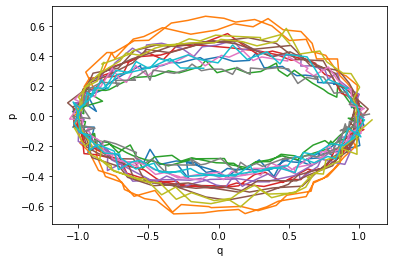

In [6]:
for i in range(10):
  plt.plot(data['q_with_noies'][i],data['p_with_noies'][i])

plt.xlabel('q')
plt.ylabel('p');

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load training data
inputs  = torch.Tensor(data['data_in'])
outputs = torch.Tensor(data['qp_dot_with_noies'])

traindata  = TensorDataset(inputs, outputs)
dataloader = DataLoader(traindata, batch_size=256,shuffle=False, num_workers= 1) # 256

## Load models

In [8]:
latent_dim = 3
aux_dim = 2
n_epochs = 500

# Initialize a baseline SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = 3, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

neural_analog_func_b = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                           hidden_dim   = 10, # layer dimensions
                           output_dim   = 2,  # output size 2 (qdot,pdot)
                           activation_func = nn.Tanh())

b_scinet_3lv03 = ConSciNet(Encoder = encoder, 
                     NAFunc = neural_analog_func_b, 
                     trial = f'Noise_lvl03_Baseline_{system}')


# Initialize a Constrained SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = latent_dim, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

diff_func = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                hidden_dim   = 10, # HNN layer dimensions
                output_dim   = 1,  # output size 1 H*
                activation_func = nn.Tanh())
         
neural_analog_func = HNN(input_dim = 2,
                         differentiable_model = diff_func
                         )

c_scinet_3lv03 = ConSciNet(Encoder = encoder, 
                     NAFunc = neural_analog_func, 
                     trial = f'Noise_lvl03_ConSciNet_{system}')

In [9]:
load_model(c_scinet_3lv03,'models/weights/Noise_lvl03_ConSciNet_spring_weights50k_lv3.pt')
load_model(b_scinet_3lv03,'models/weights/Noise_lvl03_Baseline_spring_weights50k_lv3.pt')

<All keys matched successfully>

## Results

In [10]:
def integrate_model(model, t_span, y0, lv,**kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32) #.view(1,2)
        hnn_in = torch.cat([x.squeeze(),lv[0]])
        
        #[(latent,q,p), (q,p)]
        dx = model.nafunc.time_derivative(hnn_in,x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)


def get_lv(model, model_input):
  z_list = []
  z_dim = model.encoder.latent_dim

  [z_list.append([]) for i in range(z_dim)]

  for i in range(data['x'].shape[0]):
    m = model.encoder(torch.tensor(model_input[i][:-2]).float()) #.detach().numpy()[0]
    latent_vec = model.encoder.mu.detach().numpy()
    [z_list[i].append(latent_vec[i]) for i in range(z_dim)]
  return z_list

def trj_pred(b_model,c_model, trial, model_input, t_span = [0,10], n_points = 2000, share_axis = True):

  
  c_lv = c_model.encoder(torch.tensor(model_input['data_in'][trial][:-2]).float())

  b_lv = b_model.encoder(torch.tensor(model_input['data_in'][trial][:-2]).float())

  y0 = [1,0]

  t_eval = np.linspace(t_span[0], t_span[1], n_points)
  kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
  lv = c_lv
  c_path = integrate_model(c_model, t_span, y0, lv = c_lv, **kwargs)
  lv = b_lv
  b_path = integrate_model(b_model, t_span, y0,lv = b_lv, **kwargs)
  
  #print('length = ', data['length'][trial])

  fig, axs = plt.subplots(1, 2,figsize=(10,4), sharey= share_axis, sharex= share_axis)

  axs[1].scatter(x = c_path['y'][0],y = c_path['y'][1], c = c_path['t'], cmap = 'plasma')
  c = axs[0].scatter(x = b_path['y'][0],y = b_path['y'][1], c = b_path['t'], cmap = 'plasma')

  axs[1].set_xlabel('q', fontsize = 12)
  axs[1].set_ylabel('p', fontsize = 12)
  axs[1].set_title('Constrained SciNet', fontsize = 15)
  #axs[1].plot(model_input['q'][trial],model_input['p'][trial], color = 'green', label = 'Ground truth')
  axs[1].scatter(model_input['q_with_noies'][trial],model_input['p_with_noies'][trial], color = 'black', label = 'Ground truth')

  axs[0].set_xlabel('q', fontsize = 12)
  axs[0].set_ylabel('p', fontsize = 12)
  axs[0].set_title('Baseline SciNet', fontsize = 15);
  #axs[0].plot(model_input['q'][trial],model_input['p'][trial], color = 'green', label = 'Ground truth')
  axs[0].scatter(model_input['q_with_noies'][trial],model_input['p_with_noies'][trial], color = 'black', label = 'Ground truth')


  fig.subplots_adjust(right=0.8, wspace = .3,top=0.8)
  k = np.round(model_input['k'][trial],3)
  m = np.round(model_input['m'][trial],3)
  sigma = model_input['n_level']
  fig.suptitle(f'Spring mass predictions: $\sigma = {sigma}$ | m = {m}, k = {k}',fontsize = 18);
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
  fig.colorbar(c, cax=cbar_ax).set_label('time', fontsize = '12');

  return fig


#### Phase predictions

500


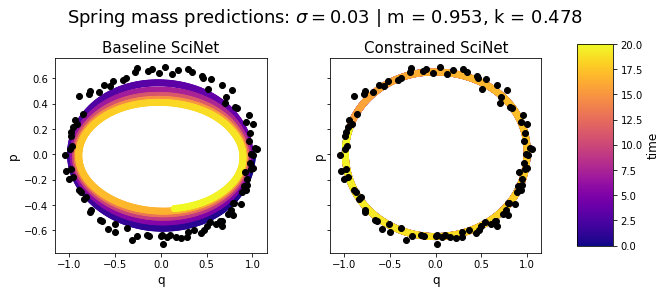

In [11]:
trial = 500 #np.random.randint(1,49000) # vary between [1,49000] to plot a different trial
print(trial)
t_span = [0,20]

fig = trj_pred(b_model = b_scinet_3lv03, c_model=c_scinet_3lv03,model_input = data, trial = trial, t_span = t_span, n_points = 2000)

### Latent variable disentanglement

In [12]:
c_latent_vec03 = get_lv(c_scinet_3lv03, model_input = data['data_in'])
b_latent_vec03 = get_lv(b_scinet_3lv03, model_input = data['data_in'])

In [13]:
def lv_plot(latent_vec, title):
  fmt = lambda x: "{:.2f}%".format(x)
  tick_marks = np.array([0.1,0.2,0.3,0.4,0.5])

  n =3
  fig = plt.figure(figsize=(30,8))
  for i in range(n):
    ax = fig.add_subplot(1, n, 1+i, projection='3d')
    surf = ax.plot_trisurf(np.array(data['k'])[:1000], np.array(data['m'])[:1000], np.array(latent_vec[i])[:1000], cmap='viridis',
                          linewidth=0, antialiased=False, edgecolor='none')
    ax.set_title(f'latent variable: {i+1}', fontsize  = 15)
    ax.set_xlabel("k",fontsize  = 15)
    ax.set_ylabel("m", fontsize = 15)
    ax.set_zlabel(f"$z_{{{i+1}}}$ activation", fontsize = 15)
    ax.set_zlim(-0.3,0.3)
    ax.set_xticks(tick_marks)
  
  fig.set_size_inches(15, 5)
  plt.tight_layout()
  fig.suptitle(title,fontsize = 20);
  plt.subplots_adjust(top=0.9, wspace=0.2)
  
  #plt.savefig('Spring_Baseline_lv_NEW.svg', format='svg',bbox_inches='tight', dpi = 300)

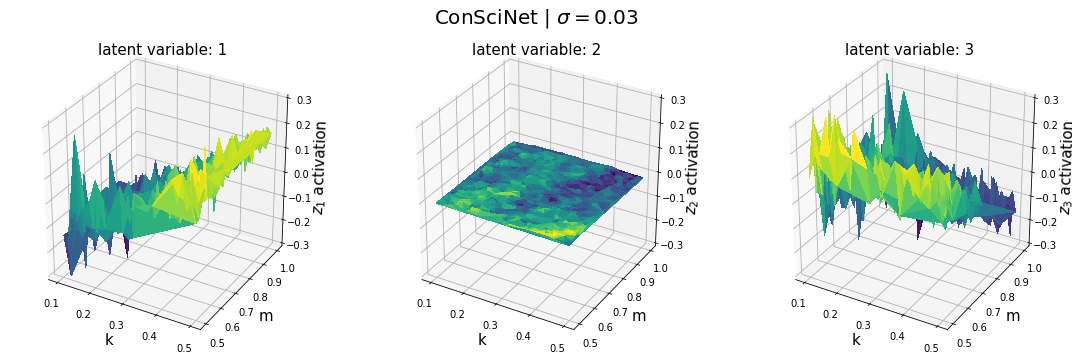

In [16]:
lv_plot(latent_vec = c_latent_vec03, title = f'ConSciNet | $\sigma = {n_level}$')

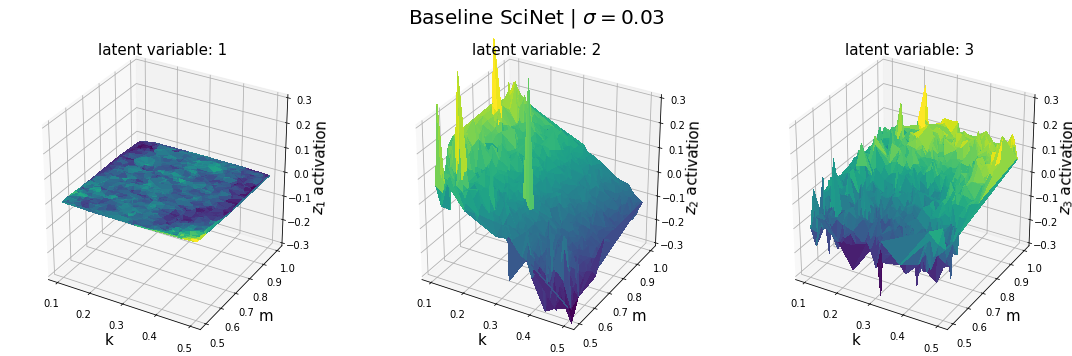

In [17]:
lv_plot(latent_vec = b_latent_vec03, title = f'Baseline SciNet | $\sigma = {n_level}$')

### Interpolation

In [18]:
poly_order = 5

model = b_scinet_3lv03
y0 = [1,0]

t_span = [0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
kwargs = {'t_eval': t_eval, 'rtol': 1e-12}  

latent_vec = b_latent_vec03

lv_pos_k = 1
lv_pos_m = 2


# model prediction
f_k =  np.poly1d(np.polyfit(data['k'],latent_vec[lv_pos_k], deg = poly_order))
f_m =  np.poly1d(np.polyfit(data['m'],latent_vec[lv_pos_m], deg = poly_order))

n = 4
k_vals = np.linspace(np.min(data['k']), np.max(data['k']),n)
m_vals = np.linspace(np.min(data['m']), np.max(data['m']),n)

k_like_vals = f_k(k_vals)
m_like_vals = f_m(m_vals)

bcc_paths = []
for lv in k_like_vals:
  pred = []
  lv_values = np.zeros(3)
  lv_values[lv_pos_k] = lv
  lv_values[lv_pos_m] = f_m(0.75) #m_like_vals[0]
  #lv_values = [0,lv,0]
  lv_values = list(lv_values)
  lv = torch.tensor([lv_values]).float()
  #print(lv)
  bcc_paths.append(integrate_model(model, t_span, y0,lv = lv, **kwargs))

bcc_paths2 = []
for i in m_like_vals:
  pred = []
  lv_values = np.zeros(3)
  lv_values[lv_pos_m] = i
  #print(lv_values)
  lv_values[lv_pos_k] = f_k(0.25)
  #lv_values = [0,lv,0]
  lv_values = list(lv_values)
  lv = torch.tensor([lv_values]).float()
  #print(lv)
  bcc_paths2.append(integrate_model(model, t_span, y0, lv = lv, **kwargs))


In [19]:
poly_order = 5

model = c_scinet_3lv03

t_span = [0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
kwargs = {'t_eval': t_eval, 'rtol': 1e-12}  

latent_vec = c_latent_vec03

lv_pos_k = 0
lv_pos_m = 2

# model prediction
f_k =  np.poly1d(np.polyfit(data['k'],latent_vec[lv_pos_k], deg = poly_order))
f_m =  np.poly1d(np.polyfit(data['m'],latent_vec[lv_pos_m], deg = poly_order))

In [20]:
n = 4
k_vals = np.linspace(np.min(data['k']), np.max(data['k']),n)
m_vals = np.linspace(np.min(data['m']), np.max(data['m']),n)

In [21]:
k_like_vals = f_k(k_vals)
m_like_vals = f_m(m_vals)

In [23]:
#ground truth
gt_paths = []
y0 = [1,0]
for k in k_vals:
  spring_params['k'] = k
  spring_params['m'] = 0.75
  gt_path = solve_ivp(fun=dynamics_fn, 
                           t_span=t_span, 
                           y0=y0, 
                           t_eval=t_eval, 
                           rtol=1e-10)
  gt_paths.append(gt_path)


gt_paths2 = []
for m in m_vals:
  spring_params['k'] = 0.25
  spring_params['m'] = m
  gt_path2 = solve_ivp(fun=dynamics_fn, 
                           t_span=t_span, 
                           y0=y0, 
                           t_eval=t_eval, 
                           rtol=1e-10)
  gt_paths2.append(gt_path2)


cc_paths = []
for lv in k_like_vals:
  pred = []
  lv_values = np.zeros(3)
  lv_values[lv_pos_k] = lv
  lv_values[lv_pos_m] = f_m(0.75) #m_like_vals[0]
  #lv_values = [0,lv,0]
  lv_values = list(lv_values)
  lv = torch.tensor([lv_values]).float()
 # print(lv)
  cc_paths.append(integrate_model(model, t_span, y0,lv = lv, **kwargs))


cc_paths2 = []
for i in m_like_vals:
  pred = []
  lv_values = np.zeros(3)
  lv_values[lv_pos_m] = i
  #print(lv_values)
  lv_values[lv_pos_k] = f_k(0.25)
  #lv_values = [0,lv,0]
  lv_values = list(lv_values)
  lv = torch.tensor([lv_values]).float()
  #print(lv)
  cc_paths2.append(integrate_model(model, t_span, y0, lv = lv, **kwargs))

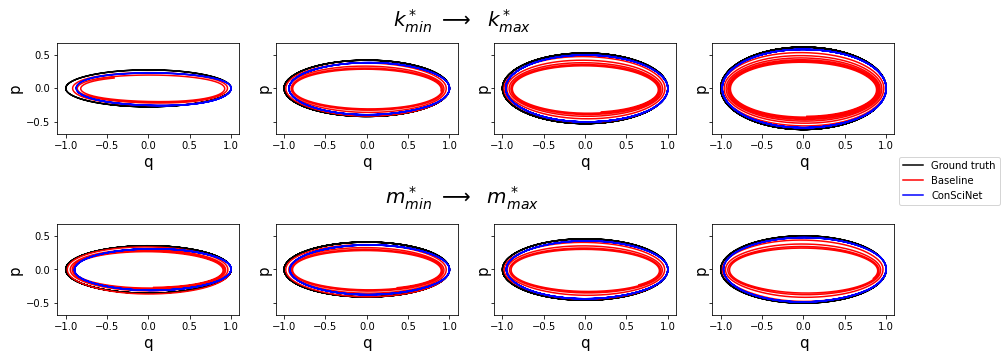

In [26]:
fig, axs = plt.subplots(2, n,figsize=(15,5), sharey=True)
for i in range(n):
  axs[0, i].plot(gt_paths[i]['y'][0],gt_paths[i]['y'][1], color = 'black', label = 'Ground truth')
  axs[0, i].plot(bcc_paths[i]['y'][0],bcc_paths[i]['y'][1], color = 'red', label = 'Baseline')
  axs[0, i].plot(cc_paths[i]['y'][0],cc_paths[i]['y'][1], color = 'blue', label = 'ConSciNet')
  
  axs[1, i].plot(gt_paths2[i]['y'][0],gt_paths2[i]['y'][1], color = 'black', label = 'Ground truth')
  axs[1, i].plot(bcc_paths2[i]['y'][0],bcc_paths2[i]['y'][1], color = 'red', label = 'Baseline')
  axs[1, i].plot(cc_paths2[i]['y'][0],cc_paths2[i]['y'][1], color = 'blue', label = 'ConSciNet')
  
  axs[0,i].set_ylabel('p', fontsize = 15)
  axs[0,i].set_xlabel('q', fontsize = 15)
  axs[1,i].set_ylabel('p', fontsize = 15)
  axs[1,i].set_xlabel('q', fontsize = 15)
  
fig.suptitle('$k_{min}^*$ $\longrightarrow$  $k_{max}^*$',fontsize = 20);
plt.legend(loc="upper left", bbox_to_anchor=(1,1.8))

# 2nd row title
plt.subplots_adjust(hspace=1)
plt.figtext(0.5, 0.45, '$m_{min}^*$ $\longrightarrow$  $m_{max}^*$', ha='center', va='center', fontsize = 20);

#plt.savefig('Spring_ConSciNet_Interpolation_NEW.svg', format='svg',bbox_inches='tight', dpi = 300)